In [65]:
# Imports
import os
import torch
import numpy as np

from tqdm import tqdm

from torchmetrics import Recall, F1Score 

from torch.utils.data import Dataset, DataLoader, random_split

from torch import nn

from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt 
import seaborn as sbn

from collections import Counter
from torchmetrics import Accuracy

In [66]:
# Dataset Class
class BrainTumorDataset(Dataset):

    # initialization
    def __init__(self, base_path_list: list, class_name_list: list, classes_img_path_list: list, transforms = None):
        # Инициализация параметров
        self.base_path_list = base_path_list 
        self.class_name_list = class_name_list
        self.classes_img_path_list = classes_img_path_list 
        self.transforms = transforms

        self.class_label_list = {k: v for k, v in enumerate(self.class_name_list)}

        self.full_list = []
        for label, class_list  in enumerate(classes_img_path_list):
            for path in class_list:
                self.full_list += [[path, label]]
        
    def __len__(self):
        return len(self.full_list)

    def __getitem__(self, idx):
        # Получить объект из списка
        obj = self.full_list[idx]

        img = Image.open(self.base_path_list[obj[1]]+"/"+obj[0]).convert("RGB")

        if self.transforms:
            img = self.transforms(img)
        
        return img, obj[1]

In [67]:
no_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no" #change this
yes_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes" #chnage this

In [68]:
no_tumor_images_list = os.listdir(no_path)
yes_tumor_images_list = os.listdir(yes_path)

In [69]:
transform = transforms.Compose([
    transforms.Resize([60, 60]),
    transforms.ToTensor()
])

In [70]:
ds = BrainTumorDataset([no_path, yes_path], ["No Tumor", "Yes Tumor"], [no_tumor_images_list, yes_tumor_images_list], transform)

In [71]:
train_ds, valid_ds, test_ds = random_split(ds, [0.70, 0.15, 0.15], generator=torch.Generator().manual_seed(42))

In [72]:
batch_size = 4 

torch.manual_seed(42)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True) # Перемешиваем для лучшего обучения
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# EDA

In [73]:
for i, cl in enumerate(os.listdir("/kaggle/input/brain-mri-images-for-brain-tumor-detection")):
    print(f"{i+1}) {cl}")

1) no
2) yes
3) brain_tumor_dataset


In [74]:
no_tumor_img_count = os.listdir("/kaggle/input/brain-mri-images-for-brain-tumor-detection/no")
yes_tumor_img_count = os.listdir("/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes")

# Получаем длину классов
no_tumor_img_count = len(os.listdir("/kaggle/input/brain-mri-images-for-brain-tumor-detection/no"))
yes_tumor_img_count = len(os.listdir("/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes"))

# Выводим информацию
print("photos without tumor:", no_tumor_img_count)
print("photos with tumor:", yes_tumor_img_count)
print("total:", no_tumor_img_count+yes_tumor_img_count)

photos without tumor: 98
photos with tumor: 155
total: 253


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


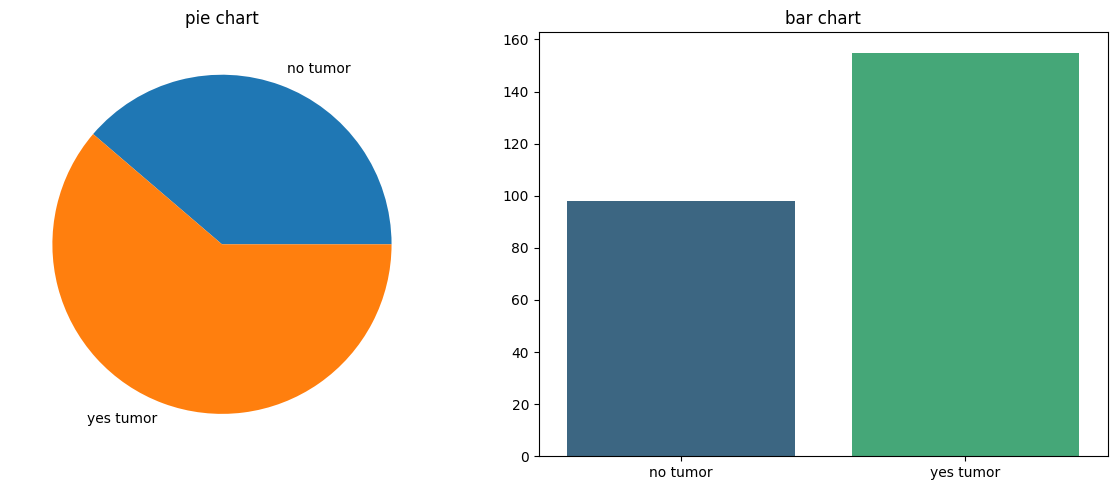

In [75]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie([no_tumor_img_count, yes_tumor_img_count], labels=["no tumor", "yes tumor"])
plt.title("pie chart")

plt.subplot(1, 2, 2)
sbn.barplot(y=[no_tumor_img_count, yes_tumor_img_count], x=["no tumor", "yes tumor"], palette='viridis', hue=None)
plt.title("bar chart")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


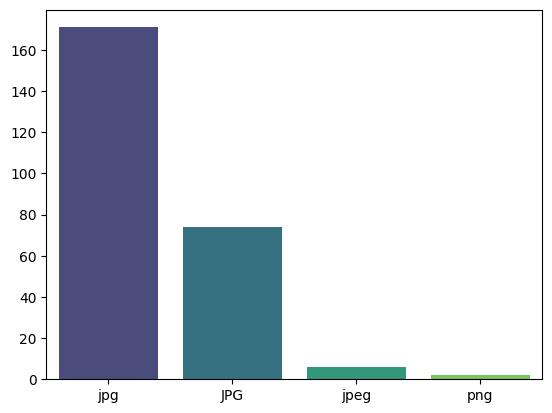

In [76]:
extensions = []
for path in no_tumor_images_list:
    extensions.append(path.split(".")[1])
for path in yes_tumor_images_list:
    extensions.append(path.split(".")[1])
extensions_counter = Counter(extensions)

sbn.barplot(x=list(extensions_counter.keys()), y=list(extensions_counter.values()), palette='viridis', hue=None)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


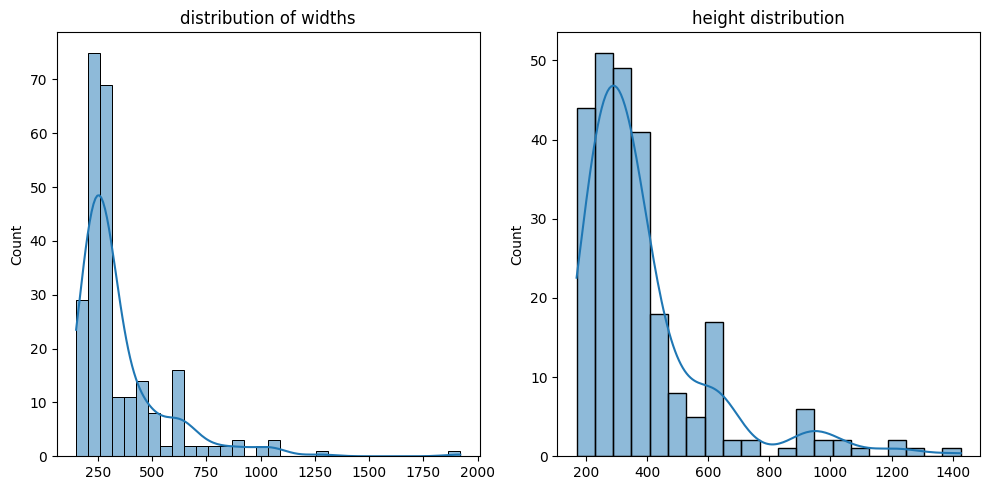

mean width: 354.24
mean height: 386.02
min size: 150x168
max size: 1920x1427


In [77]:
heights = []
widths = []
for img_name in no_tumor_images_list:
    img_path = os.path.join("/kaggle/input/brain-mri-images-for-brain-tumor-detection/no", img_name)
    with Image.open(img_path) as img:
        widths.append(img.size[0])
        heights.append(img.size[1])
for img_name in yes_tumor_images_list:
    img_path = os.path.join("/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes", img_name)
    with Image.open(img_path) as img:
        widths.append(img.size[0])
        heights.append(img.size[1])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sbn.histplot(widths, kde=True)
plt.title('distribution of widths')

plt.subplot(1, 2, 2)
sbn.histplot(heights, kde=True)
plt.title('height distribution')

plt.tight_layout()
plt.show()

print(f"mean width: {np.mean(widths):.2f}")
print(f"mean height: {np.mean(heights):.2f}")
print(f"min size: {min(widths)}x{min(heights)}")
print(f"max size: {max(widths)}x{max(heights)}")

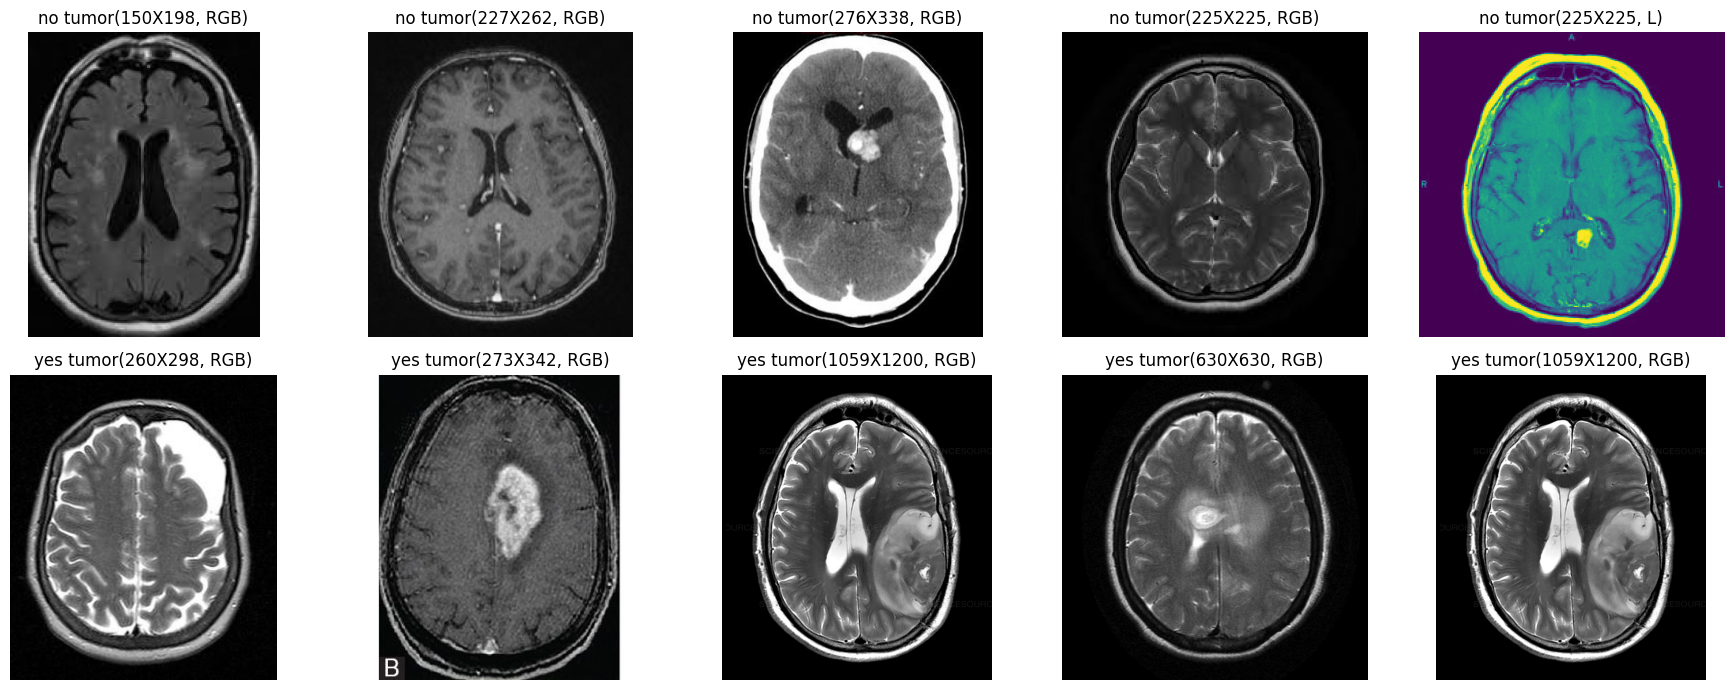

In [78]:
plt.figure(figsize=(18, 7))

for i, img_path in enumerate(no_tumor_images_list[:5]):
    plt.subplot(2, 5, i+1)
    img = Image.open("/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/"+img_path)
    plt.title(f"no tumor({img.size[0]}X{img.size[1]}, {img.mode})") 
    plt.imshow(img)
    plt.axis("off")

for i, img_path in enumerate(yes_tumor_images_list[:5]):
    plt.subplot(2, 5, i+6)
    img = Image.open("/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/"+img_path)
    plt.title(f"yes tumor({img.size[0]}X{img.size[1]}, {img.mode})")
    plt.imshow(img)
    plt.axis("off")


plt.tight_layout()
plt.show()

## CNN

In [79]:
class CNNBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, padding, pool_size):

        super().__init__()

        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.activation = nn.ReLU() 
        self.pool_layer = nn.MaxPool2d(kernel_size=pool_size)
    
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.activation(x)
        x = self.pool_layer(x)
        return x


In [80]:
class LinearBlock(nn.Module):
    def __init__(self, input_size, linear_size_1, out_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(input_size, linear_size_1)
        self.linear_2 = nn.Linear(linear_size_1, out_size)
        self.dropout = nn.Dropout(p=0.3)

        self.activation = nn.ReLU()

    def forward(self, x):

        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

In [81]:
model = nn.Sequential(
    CNNBlock(in_channels=3, out_channels=4, kernel_size=5, padding=2, pool_size=2),
    CNNBlock(in_channels=4, out_channels=8, kernel_size=5, padding=2, pool_size=2),
    LinearBlock(input_size=8*15*15, linear_size_1=32, out_size=2)
)

In [82]:
model(next(iter(train_dl))[:][0]).shape

torch.Size([4, 2])

In [83]:
# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 58810
Trainable parameters: 58810


# model traning

In [84]:
loss_fn = nn.CrossEntropyLoss()

In [85]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [86]:
epochs = 30

torch.manual_seed(42)

train_loss_journal = []
train_recall_journal = [] # Recall
train_f1_journal = [] # F1
train_acc_journal=[] #accuracy
    

valid_loss_journal = [] 
valid_recall_journal = [] # Recall
valid_f1_journal = [] # F1
valid_acc_journal=[] #accuracy

for epoch in range(epochs):
   
    train_recall = Recall(task="multiclass", num_classes=2)
    train_f1 = F1Score(task="multiclass", num_classes=2, average='macro')
    valid_recall = Recall(task="multiclass", num_classes=2)
    valid_f1 = F1Score(task="multiclass", num_classes=2, average='macro')
    train_acc = Accuracy(task="multiclass", num_classes=2)
    valid_acc = Accuracy(task="multiclass", num_classes=2)


    train_losses = []
    valid_losses = []

    progress_bar = tqdm(train_dl, desc=f"Эпоха {epoch+1}/{epochs}", leave=False) 

    model.train() 

    for x, y in progress_bar:

        batch_recall = Recall(task="multiclass", num_classes=2)
        batch_f1 = F1Score(task="multiclass", num_classes=2, average='macro')

        optimizer.zero_grad()

        preds = model(x)

        loss = loss_fn(preds, y)

        loss.backward()

        optimizer.step()

        batch_recall.update(preds, y)
        batch_f1.update(preds, y)
        progress_bar.set_postfix({
            "Loss": loss.item(),
            "Recall": batch_recall.compute().item(),
            "F1": batch_f1.compute().item()
        })

        train_recall(preds, y)
        train_f1(preds, y)

        train_losses.append(loss.item())
        train_acc.update(preds, y)
        valid_acc.update(preds, y)

    progress_bar = tqdm(valid_dl, desc=f"Эпоха {epoch+1}/{epochs}", leave=False)

    model.eval()

    with torch.no_grad(): 
        for x, y in progress_bar:

            batch_recall = Recall(task="multiclass", num_classes=2)
            batch_f1 = F1Score(task="multiclass", num_classes=2, average='macro')

            preds = model(x)

            loss = loss_fn(preds, y)

            batch_recall.update(preds, y)
            batch_f1.update(preds, y)
            progress_bar.set_postfix({
                "Loss": loss.item(),
                "Recall": batch_recall.compute().item(),
                "F1": batch_f1.compute().item()
            })

            valid_recall(preds, y)
            valid_f1(preds, y)

            valid_losses.append(loss.item())

    train_recall_journal.append(train_recall.compute())
    train_f1_journal.append(train_f1.compute())
    valid_recall_journal.append(valid_recall.compute())
    valid_f1_journal.append(valid_f1.compute())
    train_loss_journal.append(np.mean(np.array(train_losses)))
    valid_loss_journal.append(np.mean(np.array(valid_losses)))
    train_acc_journal.append(train_acc.compute())
    valid_acc_journal.append(valid_acc.compute())


    print(f"""
        Epoch {epoch+1}/{epochs}:
            Train Loss: {train_loss_journal[epoch]}, Train Recall: {train_recall_journal[epoch]}, Train F1: {train_f1_journal[epoch]};
            Valid Loss: {valid_loss_journal[epoch]}, Valid Recall: {valid_recall_journal[epoch]}, Valid F1: {valid_f1_journal[epoch]};
            print(f"Train Acc: {train_acc.compute():.2f}, Valid Acc: {valid_acc.compute():.2f}")
    """)


        Epoch 1/30:
            Train Loss: 0.6667290329933167, Train Recall: 0.6067415475845337, Train F1: 0.44543349742889404;
            Valid Loss: 0.5462368935346603, Valid Recall: 0.7894737124443054, Valid F1: 0.744107723236084;
            print(f"Train Acc: 0.61, Valid Acc: 0.61")
    



        Epoch 2/30:
            Train Loss: 0.5654063026110331, Train Recall: 0.7247191071510315, Train F1: 0.7000997066497803;
            Valid Loss: 0.5090603590011596, Valid Recall: 0.7894737124443054, Valid F1: 0.7564102411270142;
            print(f"Train Acc: 0.72, Valid Acc: 0.72")
    



        Epoch 3/30:
            Train Loss: 0.52481313612726, Train Recall: 0.7640449404716492, Train F1: 0.7514958381652832;
            Valid Loss: 0.5042366445064544, Valid Recall: 0.7631579041481018, Valid F1: 0.7317646741867065;
            print(f"Train Acc: 0.76, Valid Acc: 0.76")
    



        Epoch 4/30:
            Train Loss: 0.5495689686801698, Train Recall: 0.7640449404716492, Train F1: 0.7438322305679321;
            Valid Loss: 0.5134265840053558, Valid Recall: 0.7368420958518982, Valid F1: 0.7076923251152039;
            print(f"Train Acc: 0.76, Valid Acc: 0.76")
    



        Epoch 5/30:
            Train Loss: 0.5057055513064067, Train Recall: 0.7640449404716492, Train F1: 0.7486889958381653;
            Valid Loss: 0.5402312099933624, Valid Recall: 0.7105262875556946, Valid F1: 0.6840513944625854;
            print(f"Train Acc: 0.76, Valid Acc: 0.76")
    



        Epoch 6/30:
            Train Loss: 0.47793197565608553, Train Recall: 0.8033707737922668, Train F1: 0.7886344194412231;
            Valid Loss: 0.524906313419342, Valid Recall: 0.7368420958518982, Valid F1: 0.7076923251152039;
            print(f"Train Acc: 0.80, Valid Acc: 0.80")
    



        Epoch 7/30:
            Train Loss: 0.4726289735900031, Train Recall: 0.7808988690376282, Train F1: 0.7629340887069702;
            Valid Loss: 0.5635264545679093, Valid Recall: 0.7105262875556946, Valid F1: 0.69332355260849;
            print(f"Train Acc: 0.78, Valid Acc: 0.78")
    



        Epoch 8/30:
            Train Loss: 0.45953104082081053, Train Recall: 0.7977527976036072, Train F1: 0.7845905423164368;
            Valid Loss: 0.5706784799695015, Valid Recall: 0.7368420958518982, Valid F1: 0.7172619104385376;
            print(f"Train Acc: 0.80, Valid Acc: 0.80")
    



        Epoch 9/30:
            Train Loss: 0.4075996372434828, Train Recall: 0.8314606547355652, Train F1: 0.8215240836143494;
            Valid Loss: 0.6042874589562416, Valid Recall: 0.7105262875556946, Valid F1: 0.69332355260849;
            print(f"Train Acc: 0.83, Valid Acc: 0.83")
    



        Epoch 10/30:
            Train Loss: 0.4119363938768705, Train Recall: 0.7865168452262878, Train F1: 0.7763227224349976;
            Valid Loss: 0.5906671404838562, Valid Recall: 0.7105262875556946, Valid F1: 0.69332355260849;
            print(f"Train Acc: 0.79, Valid Acc: 0.79")
    



        Epoch 11/30:
            Train Loss: 0.35160613821612463, Train Recall: 0.8539325594902039, Train F1: 0.8469576835632324;
            Valid Loss: 0.557024085521698, Valid Recall: 0.7368420958518982, Valid F1: 0.7076923251152039;
            print(f"Train Acc: 0.85, Valid Acc: 0.85")
    



        Epoch 12/30:
            Train Loss: 0.3420025933947828, Train Recall: 0.8764045238494873, Train F1: 0.8711333274841309;
            Valid Loss: 0.7249767817556858, Valid Recall: 0.6842105388641357, Valid F1: 0.6695652008056641;
            print(f"Train Acc: 0.88, Valid Acc: 0.88")
    



        Epoch 13/30:
            Train Loss: 0.31663957527942127, Train Recall: 0.8595505356788635, Train F1: 0.8532079458236694;
            Valid Loss: 0.5817892462015152, Valid Recall: 0.7105262875556946, Valid F1: 0.6840513944625854;
            print(f"Train Acc: 0.86, Valid Acc: 0.86")
    



        Epoch 14/30:
            Train Loss: 0.2954014457762241, Train Recall: 0.882022500038147, Train F1: 0.8772776126861572;
            Valid Loss: 0.5288099817931652, Valid Recall: 0.7368420958518982, Valid F1: 0.7076923251152039;
            print(f"Train Acc: 0.88, Valid Acc: 0.88")
    



        Epoch 15/30:
            Train Loss: 0.2274874844484859, Train Recall: 0.9213483333587646, Train F1: 0.9179939031600952;
            Valid Loss: 0.7627089835703373, Valid Recall: 0.7105262875556946, Valid F1: 0.6840513944625854;
            print(f"Train Acc: 0.92, Valid Acc: 0.92")
    



        Epoch 16/30:
            Train Loss: 0.22661913473986917, Train Recall: 0.915730357170105, Train F1: 0.9119248390197754;
            Valid Loss: 0.725222346931696, Valid Recall: 0.7105262875556946, Valid F1: 0.6840513944625854;
            print(f"Train Acc: 0.92, Valid Acc: 0.92")
    



        Epoch 17/30:
            Train Loss: 0.1599539409702023, Train Recall: 0.9213483333587646, Train F1: 0.9183700084686279;
            Valid Loss: 0.8078978031873703, Valid Recall: 0.6842105388641357, Valid F1: 0.6607142686843872;
            print(f"Train Acc: 0.92, Valid Acc: 0.92")
    



        Epoch 18/30:
            Train Loss: 0.11782246044733458, Train Recall: 0.9550561904907227, Train F1: 0.9531394243240356;
            Valid Loss: 0.7595649525523186, Valid Recall: 0.7105262875556946, Valid F1: 0.6840513944625854;
            print(f"Train Acc: 0.96, Valid Acc: 0.96")
    



        Epoch 19/30:
            Train Loss: 0.1595779969667395, Train Recall: 0.9382022619247437, Train F1: 0.9354115128517151;
            Valid Loss: 0.7934219323098659, Valid Recall: 0.7368420958518982, Valid F1: 0.7172619104385376;
            print(f"Train Acc: 0.94, Valid Acc: 0.94")
    



        Epoch 20/30:
            Train Loss: 0.09515481974101729, Train Recall: 0.9719101190567017, Train F1: 0.9707803726196289;
            Valid Loss: 1.0363956585526466, Valid Recall: 0.6842105388641357, Valid F1: 0.6695652008056641;
            print(f"Train Acc: 0.97, Valid Acc: 0.97")
    



        Epoch 21/30:
            Train Loss: 0.11410685825653168, Train Recall: 0.9606741666793823, Train F1: 0.9588982462882996;
            Valid Loss: 0.7493688683956862, Valid Recall: 0.7368420958518982, Valid F1: 0.7172619104385376;
            print(f"Train Acc: 0.96, Valid Acc: 0.96")
    



        Epoch 22/30:
            Train Loss: 0.09935750738303695, Train Recall: 0.966292142868042, Train F1: 0.9646825194358826;
            Valid Loss: 1.0887888664379717, Valid Recall: 0.7368420958518982, Valid F1: 0.7301136255264282;
            print(f"Train Acc: 0.97, Valid Acc: 0.97")
    



        Epoch 23/30:
            Train Loss: 0.08173395212377525, Train Recall: 0.9606741666793823, Train F1: 0.959274411201477;
            Valid Loss: 0.884178290516138, Valid Recall: 0.7368420958518982, Valid F1: 0.7246376872062683;
            print(f"Train Acc: 0.96, Valid Acc: 0.96")
    



        Epoch 24/30:
            Train Loss: 0.06682065684710525, Train Recall: 0.9775280952453613, Train F1: 0.9767775535583496;
            Valid Loss: 0.7407211756333709, Valid Recall: 0.7631579041481018, Valid F1: 0.7414966225624084;
            print(f"Train Acc: 0.98, Valid Acc: 0.98")
    



        Epoch 25/30:
            Train Loss: 0.053962121361109894, Train Recall: 0.983146071434021, Train F1: 0.9824682474136353;
            Valid Loss: 0.6843981467187404, Valid Recall: 0.7631579041481018, Valid F1: 0.7414966225624084;
            print(f"Train Acc: 0.98, Valid Acc: 0.98")
    



        Epoch 26/30:
            Train Loss: 0.058454326474263026, Train Recall: 0.9719101190567017, Train F1: 0.9706416130065918;
            Valid Loss: 0.7025704937055707, Valid Recall: 0.7894737124443054, Valid F1: 0.7564102411270142;
            print(f"Train Acc: 0.97, Valid Acc: 0.97")
    



        Epoch 27/30:
            Train Loss: 0.05751108003637961, Train Recall: 0.9775280952453613, Train F1: 0.976569652557373;
            Valid Loss: 0.7898135985247791, Valid Recall: 0.7631579041481018, Valid F1: 0.7414966225624084;
            print(f"Train Acc: 0.98, Valid Acc: 0.98")
    



        Epoch 28/30:
            Train Loss: 0.0378157419660258, Train Recall: 0.983146071434021, Train F1: 0.9824682474136353;
            Valid Loss: 0.8184416032396257, Valid Recall: 0.7631579041481018, Valid F1: 0.7414966225624084;
            print(f"Train Acc: 0.98, Valid Acc: 0.98")
    



        Epoch 29/30:
            Train Loss: 0.04372032979784611, Train Recall: 0.9887640476226807, Train F1: 0.9883385896682739;
            Valid Loss: 0.8006776250898838, Valid Recall: 0.7631579041481018, Valid F1: 0.7414966225624084;
            print(f"Train Acc: 0.99, Valid Acc: 0.99")
    



        Epoch 30/30:
            Train Loss: 0.036659476212258194, Train Recall: 0.9887640476226807, Train F1: 0.9883385896682739;
            Valid Loss: 0.9976991488132626, Valid Recall: 0.6842105388641357, Valid F1: 0.6695652008056641;
            print(f"Train Acc: 0.99, Valid Acc: 0.99")
    


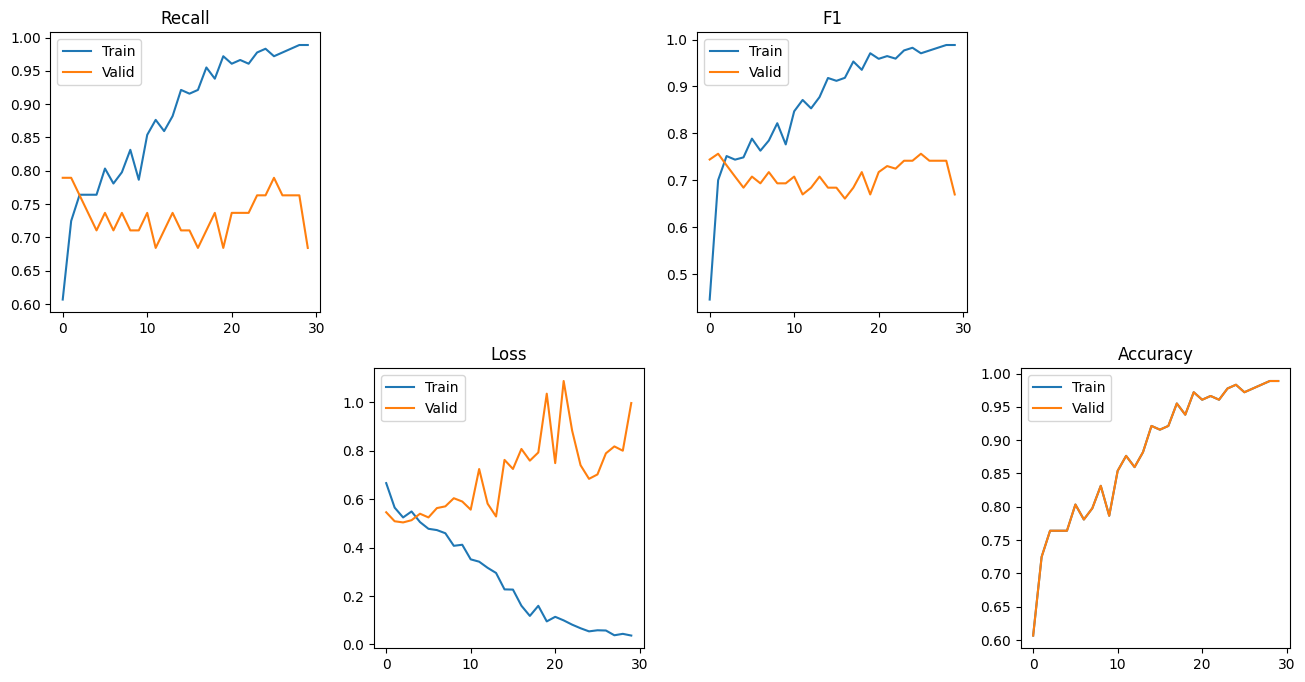

In [91]:

plt.figure(figsize=(16, 8))

# Recall
plt.subplot(2, 4, 1)
plt.title("Recall")
plt.plot(train_recall_journal, label="Train")
plt.plot(valid_recall_journal, label="Valid")
plt.legend()

# F1
plt.subplot(2, 4, 3)
plt.title("F1")
plt.plot(train_f1_journal, label="Train")
plt.plot(valid_f1_journal, label="Valid")
plt.legend()

# Loss
plt.subplot(2, 4, 6)
plt.title("Loss")
plt.plot(train_loss_journal, label="Train")
plt.plot(valid_loss_journal, label="Valid")
plt.legend()

#accuracy
plt.subplot(2, 4, 8)
plt.title("Accuracy")
plt.plot(train_acc_journal, label="Train")
plt.plot(valid_acc_journal, label="Valid")
plt.legend()

plt.show()

In [88]:
test_recall = Recall(task="multiclass", num_classes=2)
test_f1 = Recall(task="multiclass", num_classes=2, average="macro")

model.eval()

with torch.no_grad(): 
    for x_batch, y_batch in test_dl:
        preds = model(x_batch)

        test_recall.update(preds, y_batch)
        test_f1.update(preds, y_batch)

print(f"Test Recall: {test_recall.compute():.2f}")
print(f"Test F1: {test_f1.compute():.2f}")


Test Recall: 0.81
Test F1: 0.79


In [89]:
test_acc = Accuracy(task="multiclass", num_classes=2)

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        preds = model(x_batch)
        test_acc.update(preds, y_batch)

print(f"Test Accuracy: {test_acc.compute():.2f}")


Test Accuracy: 0.81


In [90]:
full_recall = Recall(task="multiclass", num_classes=2)
full_f1 = Recall(task="multiclass", num_classes=2, average="macro")

model.eval() 

with torch.no_grad():
    for x, y in ds:

        x = x.unsqueeze(0)
        y = torch.tensor([y])

        preds = model(x)

        full_recall.update(preds, y)
        full_f1.update(preds, y)

print(f"Full Recall: {full_recall.compute():.2f}")
print(f"Full F1: {full_f1.compute():.2f}")

Full Recall: 0.92
Full F1: 0.92
